Epoch 1/10, Train Loss: 0.6048, Validation AUC not computed: Only one class present in y_true.
Epoch 2/10, Train Loss: 0.5320, Validation AUC not computed: Only one class present in y_true.
Epoch 3/10, Train Loss: 0.4664, Validation AUC not computed: Only one class present in y_true.
Epoch 4/10, Train Loss: 0.4080, Validation AUC not computed: Only one class present in y_true.
Epoch 5/10, Train Loss: 0.3567, Validation AUC not computed: Only one class present in y_true.
Epoch 6/10, Train Loss: 0.3118, Validation AUC not computed: Only one class present in y_true.
Epoch 7/10, Train Loss: 0.2729, Validation AUC not computed: Only one class present in y_true.
Epoch 8/10, Train Loss: 0.2392, Validation AUC not computed: Only one class present in y_true.
Epoch 9/10, Train Loss: 0.2100, Validation AUC not computed: Only one class present in y_true.
Epoch 10/10, Train Loss: 0.1849, Validation AUC not computed: Only one class present in y_true.


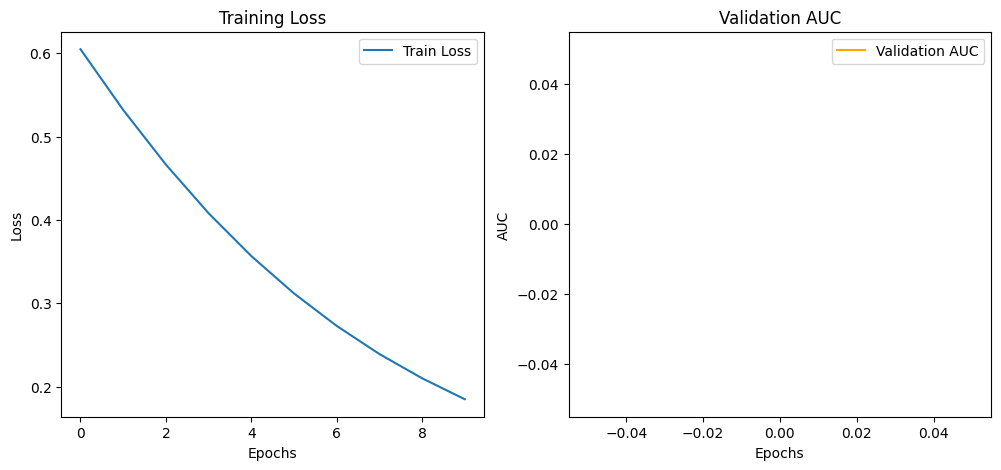

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Dataset class
class StudentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

# Model
class DKTModel(nn.Module):
    def __init__(self, num_questions, hidden_dim):
        super(DKTModel, self).__init__()
        self.embedding = nn.Embedding(num_questions, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        logits = self.fc(out[:, -1, :])  # Output of last timestep
        return torch.sigmoid(logits)

# Training loop
def train_model(model, train_loader, val_loader, epochs, lr):
    criterion = nn.BCELoss()  # You can modify this with class weights if needed
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_aucs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                y_true.extend(targets.tolist())  # Append true labels
                y_pred.append(outputs.item())    # Append single scalar output

        # Only compute ROC AUC if both classes are present
        if len(set(y_true)) > 1:  # Ensure that both 0 and 1 are in y_true
            val_auc = roc_auc_score(y_true, y_pred)
            val_aucs.append(val_auc)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val AUC: {val_auc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation AUC not computed: Only one class present in y_true.")

    return train_losses, val_aucs

# Visualize training performance
def plot_training(train_losses, val_aucs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_aucs, label="Validation AUC", color="orange")
    plt.title("Validation AUC")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.legend()

    plt.show()

# Main script
if __name__ == "__main__":
    # Example data (replace with your actual data)
    sequences = [
        [1, 2, 3],
        [4, 5, 6],
        [2, 3, 4],
        [1, 3, 5]
    ]

    labels = [
        1,  # Correct
        0,  # Incorrect
        1,  # Correct
        0   # Incorrect
    ]

    # Adjust question IDs to be zero-based
    sequences = [[q - 1 for q in seq] for seq in sequences]  # Subtract 1 from each question ID

    # Train-test split
    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        sequences, labels, test_size=0.2, random_state=42
    )

    # DataLoaders
    train_dataset = StudentDataset(train_sequences, train_labels)
    val_dataset = StudentDataset(val_sequences, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Model initialization
    num_questions = max([max(seq) for seq in sequences]) + 1  # Adjust to max question ID + 1
    model = DKTModel(num_questions, hidden_dim=64)

    # Train the model
    train_losses, val_aucs = train_model(model, train_loader, val_loader, epochs=10, lr=0.001)

    # Plot training performance
    plot_training(train_losses, val_aucs)